# Stage 11 — Model Evaluation & Risk Communication

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

PROC = Path("../data/processed")
pred_path = PROC / "IYR_predictions_stage10b.csv"   # output from Stage 10b
df = pd.read_csv(pred_path, parse_dates=["Date"]).dropna()
df = df.sort_values("Date").reset_index(drop=True)
df.head()

,Date,y_actual,y_pred
0,2023-08-08,81.718536,81.802842
1,2023-08-09,81.405876,81.827549
2,2023-08-10,81.566948,81.755125
3,2023-08-11,80.998466,82.043857
4,2023-08-14,80.032059,81.736057


In [3]:
y_true = df["y_actual"].values
y_pred = df["y_pred"].values

mae  = mean_absolute_error(y_true, y_pred)
mse  = mean_squared_error(y_true, y_pred)   # older sklearn compat
rmse = np.sqrt(mse)
r2   = r2_score(y_true, y_pred)

{"MAE": mae, "RMSE": rmse, "R2": r2}

{'MAE': 1.0584523593285873,
 'RMSE': np.float64(1.4217066078107683),
 'R2': 0.9101066138923042}

MAE 95% CI: (np.float64(0.8703645851294888), np.float64(1.2553764766777962))


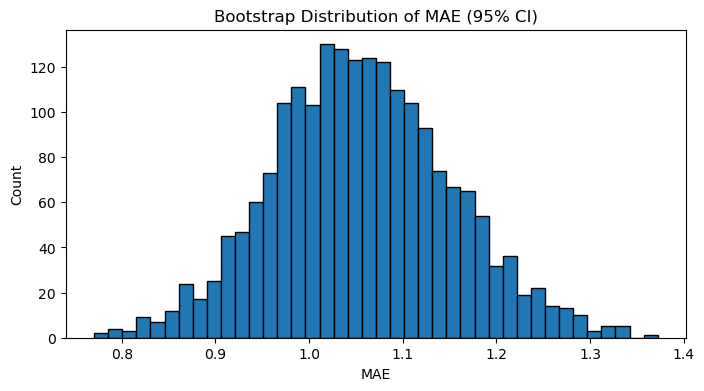

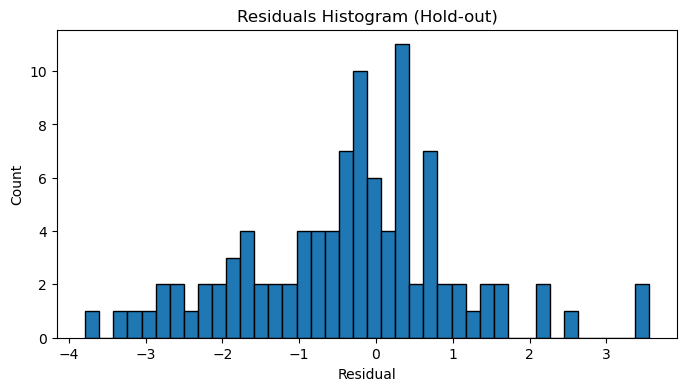

In [4]:
rng = np.random.default_rng(42)
n = len(y_true)
B = 2000
boot = np.empty(B)
for b in range(B):
    idx = rng.integers(0, n, size=n)
    boot[b] = mean_absolute_error(y_true[idx], y_pred[idx])

ci_low, ci_high = np.percentile(boot, [2.5, 97.5])
print("MAE 95% CI:", (ci_low, ci_high))

plt.figure(figsize=(8,4))
plt.hist(boot, bins=40, edgecolor="k")
plt.title("Bootstrap Distribution of MAE (95% CI)")
plt.xlabel("MAE"); plt.ylabel("Count"); plt.show()

resid = y_true - y_pred
plt.figure(figsize=(8,4))
plt.hist(resid, bins=40, edgecolor="k")
plt.title("Residuals Histogram (Hold-out)")
plt.xlabel("Residual"); plt.ylabel("Count"); plt.show()

In [5]:
# Naive: predict next day's Close as today's Close (shift by 1)
y_pred_naive = df["y_actual"].shift(1).bfill().values

mae_model  = mean_absolute_error(y_true, y_pred)
rmse_model = np.sqrt(mean_squared_error(y_true, y_pred))
mae_naive  = mean_absolute_error(y_true, y_pred_naive)
rmse_naive = np.sqrt(mean_squared_error(y_true, y_pred_naive))

comp = pd.DataFrame({
    "scenario": ["Model(Stage10b)", "Naive(persist)"],
    "MAE": [mae_model, mae_naive],
    "RMSE": [rmse_model, rmse_naive],
})
comp

,scenario,MAE,RMSE
0,Model(Stage10b),1.058452,1.421707
1,Naive(persist),0.753616,1.025332


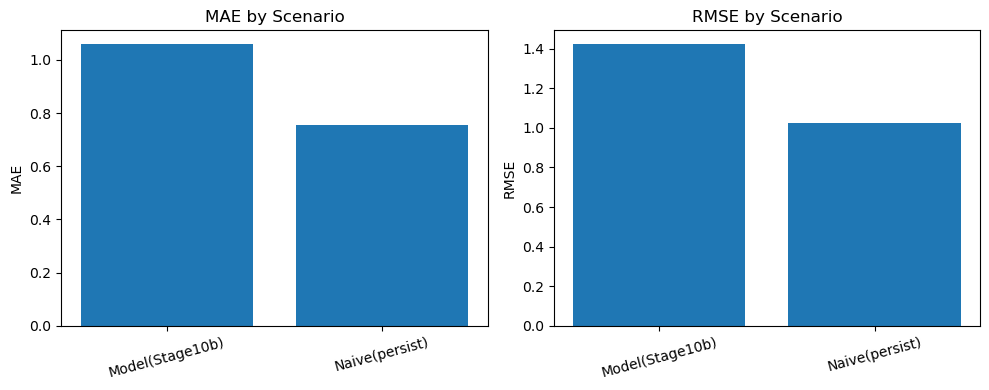

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].bar(comp["scenario"], comp["MAE"])
axes[0].set_title("MAE by Scenario"); axes[0].set_ylabel("MAE"); axes[0].tick_params(axis='x', rotation=15)
axes[1].bar(comp["scenario"], comp["RMSE"])
axes[1].set_title("RMSE by Scenario"); axes[1].set_ylabel("RMSE"); axes[1].tick_params(axis='x', rotation=15)
plt.tight_layout(); plt.show()

## Discussion — Assumptions, Risks, and Takeaways

**Assumptions**  
- Features were computed without look-ahead; Stage 10 used time-aware split.  
- Stationarity not strictly enforced; trees can model some non-linearities.

**Risks**  
- Financial data has fat tails and regime shifts; errors may not be normal.  
- Model performance can degrade under new regimes (rates/inflation shocks).

**Scenario Takeaway**  
- If Model (Stage 10b) beats Naive on MAE/RMSE, it adds value; else revisit features or target.  

**Uncertainty**  
- Bootstrap CI shows MAE variability; communicate ranges, not just a single score.